In [139]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
from symspellpy import Verbosity, SymSpell
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import xgboost as xgb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from tensorflow.keras.models import Model

In [140]:
df = pd.read_csv("Tweets.csv")
df.head()

,Datetime,Tweet Id,Text,Username
0,2020-11-05 23:34:24+00:00,1.324500e+18,"Pakistani Army Extracts From Its Own Farmers, Farmers Protest, Then Showers Bullets ANN https://t.co/VZ8XWm81yd",HindiNewsLates1
1,2020-11-05 22:09:16+00:00,1.324470e+18,{editor} Non-stun export ban sparks mass farmer protests across Poland https://t.co/NmldFUH7iN,ukagri
2,2020-11-05 21:57:50+00:00,1.324470e+18,"PTI itself kept Islamabad hijacked for months in attempt to throw the democratic government of PML-N but can’t bear protest of rights groups. It’s administration used baton charge, tear gas and chemical laden water against protesting farmers which killed Ashfaq Langriyal. https://t.co/CHTt9x6avI",Gulalai_Ismail
3,2020-11-05 21:54:22+00:00,1.324470e+18,Malik Ishfaq Langrial passes away after Punjab Police torture. He sustained injuries yesterday during protest in Lahore demanding farmers' rights https://t.co/Vp8IqcLrGY,AanuJanu1
4,2020-11-05 21:30:24+00:00,1.324460e+18,"Farmers postpone protest after baton-charge, arrests – Pakistan https://t.co/hbLU5wFpY0",RelationsState


In [141]:
df.shape[0]

17165

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17165 entries, 0 to 17164
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  17165 non-null  object 
 1   Tweet Id  17165 non-null  float64
 2   Text      17165 non-null  object 
 3   Username  17165 non-null  object 
dtypes: float64(1), object(3)
memory usage: 536.5+ KB


In [143]:
df.loc[df.duplicated()]

,Datetime,Tweet Id,Text,Username


In [144]:
def remove_usermentions(text):
    nomentions = re.sub("@[A-Za-z0-9_]+","", text)
    return nomentions

In [145]:
def remove_hashtags(text):
    nohash = re.sub("#[A-Za-z0-9_]+","", text)
    return nohash

In [146]:
def remove_url(text):
    nourl = re.sub('http://\S+|https://\S+', '', text)
    return nourl

In [147]:
def remove_nonenglish(text):
    english = [i for i in text if not re.findall("[^\u0000-\u05C0\u2100-\u214F]+", i)]
    english = "".join(english)
    return english

In [148]:
def remove_extraspaces(text):
    result = ' '.join(text.split())
    return repr(result)

In [149]:
df['clean_comment'] = df['Text'].apply(lambda x: remove_usermentions(x))
df['clean_comment'] = df['clean_comment'].apply(lambda x: remove_hashtags(x))
df['clean_comment'] = df['clean_comment'].apply(lambda x: remove_url(x))
df['clean_comment'] = df['clean_comment'].apply(lambda x: remove_nonenglish(x))
df['clean_comment'] = df['clean_comment'].apply(lambda x: remove_extraspaces(x))

In [150]:
pd.set_option('display.max_colwidth', None)

In [151]:
df.head(20)

,Datetime,Tweet Id,Text,Username,clean_comment
0,2020-11-05 23:34:24+00:00,1.324500e+18,"Pakistani Army Extracts From Its Own Farmers, Farmers Protest, Then Showers Bullets ANN https://t.co/VZ8XWm81yd",HindiNewsLates1,"'Pakistani Army Extracts From Its Own Farmers, Farmers Protest, Then Showers Bullets ANN'"
1,2020-11-05 22:09:16+00:00,1.324470e+18,{editor} Non-stun export ban sparks mass farmer protests across Poland https://t.co/NmldFUH7iN,ukagri,'{editor} Non-stun export ban sparks mass farmer protests across Poland'
2,2020-11-05 21:57:50+00:00,1.324470e+18,"PTI itself kept Islamabad hijacked for months in attempt to throw the democratic government of PML-N but can’t bear protest of rights groups. It’s administration used baton charge, tear gas and chemical laden water against protesting farmers which killed Ashfaq Langriyal. https://t.co/CHTt9x6avI",Gulalai_Ismail,"'PTI itself kept Islamabad hijacked for months in attempt to throw the democratic government of PML-N but cant bear protest of rights groups. Its administration used baton charge, tear gas and chemical laden water against protesting farmers which killed Ashfaq Langriyal.'"
3,2020-11-05 21:54:22+00:00,1.324470e+18,Malik Ishfaq Langrial passes away after Punjab Police torture. He sustained injuries yesterday during protest in Lahore demanding farmers' rights https://t.co/Vp8IqcLrGY,AanuJanu1,"""Malik Ishfaq Langrial passes away after Punjab Police torture. He sustained injuries yesterday during protest in Lahore demanding farmers' rights"""
4,2020-11-05 21:30:24+00:00,1.324460e+18,"Farmers postpone protest after baton-charge, arrests – Pakistan https://t.co/hbLU5wFpY0",RelationsState,"'Farmers postpone protest after baton-charge, arrests Pakistan'"
5,2020-11-05 21:06:34+00:00,1.324460e+18,Fascist regime of @ImranKhanPTI is worst than war criminals. We heard about use of chemical weapons in wars but never heard someone used on it's own civilans. Yes it's happening in Pakistan by police on the protest. One died when police thrown chemical mixed water on farmers. https://t.co/tNNWIEaZfI,Faisal_hashmii,"""Fascist regime of is worst than war criminals. We heard about use of chemical weapons in wars but never heard someone used on it's own civilans. Yes it's happening in Pakistan by police on the protest. One died when police thrown chemical mixed water on farmers."""
6,2020-11-05 20:57:35+00:00,1.324460e+18,"@slsandpet @Anna98831 Questions here @ScottMorrisonMP, ppl have questions.\n#australia #FarmersProtest #Farmers #Farmer \n#auspol #AuspolSoCorrupt https://t.co/uObYUEYHWy",John_M_bps,"'Questions here , ppl have questions.'"
7,2020-11-05 20:57:19+00:00,1.324460e+18,There was a time when Khan sb used to narrate Umar R.A that an emperor is responsible for the dog killed by thirst. so now who will take the responsibility?? \nhow can you prosecute model town incident if you r being reckless &amp; tyrant too? #FarmersProtest,iamzaynashraf,'There was a time when Khan sb used to narrate Umar R.A that an emperor is responsible for the dog killed by thirst. so now who will take the responsibility?? how can you prosecute model town incident if you r being reckless &amp; tyrant too?'
8,2020-11-05 20:17:03+00:00,1.324450e+18,PPP Thatta info sec Syed Mehmood Shah expressed deep grief over death of Malik Ishfaq Langrial after Punjab Police torture. He sustained injuries yesterday during protest in Lahore demanding farmers' rights.\n\n@BBhuttoZardari @MacMehmoodshah https://t.co/xgGhW5jvmd,HumairIqbal1,"""PPP Thatta info sec Syed Mehmood Shah expressed deep grief over death of Malik Ishfaq Langrial after Punjab Police torture. He sustained injuries yesterday during protest in Lahore demanding farmers' rights."""
9,2020-11-05 20:11:46+00:00,1.324440e+18,If the politicians protest for their vote bank the police provide them peaceful environment..as same as a farmer men protest for their rights..why the policemen change their attitude towards them..\n#کسان_کا_قاتل_عمران_خان https://t

In [152]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [153]:
def remove_punctuation(text):
    puncfree=[i for i in text if i not in string.punctuation]
    puncfree = "".join(puncfree)
    return puncfree

In [154]:
df['clean_comment'] = df.clean_comment.apply(remove_punctuation)
df.head()

,Datetime,Tweet Id,Text,Username,clean_comment
0,2020-11-05 23:34:24+00:00,1.324500e+18,"Pakistani Army Extracts From Its Own Farmers, Farmers Protest, Then Showers Bullets ANN https://t.co/VZ8XWm81yd",HindiNewsLates1,Pakistani Army Extracts From Its Own Farmers Farmers Protest Then Showers Bullets ANN
1,2020-11-05 22:09:16+00:00,1.324470e+18,{editor} Non-stun export ban sparks mass farmer protests across Poland https://t.co/NmldFUH7iN,ukagri,editor Nonstun export ban sparks mass farmer protests across Poland
2,2020-11-05 21:57:50+00:00,1.324470e+18,"PTI itself kept Islamabad hijacked for months in attempt to throw the democratic government of PML-N but can’t bear protest of rights groups. It’s administration used baton charge, tear gas and chemical laden water against protesting farmers which killed Ashfaq Langriyal. https://t.co/CHTt9x6avI",Gulalai_Ismail,PTI itself kept Islamabad hijacked for months in attempt to throw the democratic government of PMLN but cant bear protest of rights groups Its administration used baton charge tear gas and chemical laden water against protesting farmers which killed Ashfaq Langriyal
3,2020-11-05 21:54:22+00:00,1.324470e+18,Malik Ishfaq Langrial passes away after Punjab Police torture. He sustained injuries yesterday during protest in Lahore demanding farmers' rights https://t.co/Vp8IqcLrGY,AanuJanu1,Malik Ishfaq Langrial passes away after Punjab Police torture He sustained injuries yesterday during protest in Lahore demanding farmers rights
4,2020-11-05 21:30:24+00:00,1.324460e+18,"Farmers postpone protest after baton-charge, arrests – Pakistan https://t.co/hbLU5wFpY0",RelationsState,Farmers postpone protest after batoncharge arrests Pakistan


In [155]:
df['clean_comment'] = df['clean_comment'].apply(lambda x: x.lower())
df.head()

,Datetime,Tweet Id,Text,Username,clean_comment
0,2020-11-05 23:34:24+00:00,1.324500e+18,"Pakistani Army Extracts From Its Own Farmers, Farmers Protest, Then Showers Bullets ANN https://t.co/VZ8XWm81yd",HindiNewsLates1,pakistani army extracts from its own farmers farmers protest then showers bullets ann
1,2020-11-05 22:09:16+00:00,1.324470e+18,{editor} Non-stun export ban sparks mass farmer protests across Poland https://t.co/NmldFUH7iN,ukagri,editor nonstun export ban sparks mass farmer protests across poland
2,2020-11-05 21:57:50+00:00,1.324470e+18,"PTI itself kept Islamabad hijacked for months in attempt to throw the democratic government of PML-N but can’t bear protest of rights groups. It’s administration used baton charge, tear gas and chemical laden water against protesting farmers which killed Ashfaq Langriyal. https://t.co/CHTt9x6avI",Gulalai_Ismail,pti itself kept islamabad hijacked for months in attempt to throw the democratic government of pmln but cant bear protest of rights groups its administration used baton charge tear gas and chemical laden water against protesting farmers which killed ashfaq langriyal
3,2020-11-05 21:54:22+00:00,1.324470e+18,Malik Ishfaq Langrial passes away after Punjab Police torture. He sustained injuries yesterday during protest in Lahore demanding farmers' rights https://t.co/Vp8IqcLrGY,AanuJanu1,malik ishfaq langrial passes away after punjab police torture he sustained injuries yesterday during protest in lahore demanding farmers rights
4,2020-11-05 21:30:24+00:00,1.324460e+18,"Farmers postpone protest after baton-charge, arrests – Pakistan https://t.co/hbLU5wFpY0",RelationsState,farmers postpone protest after batoncharge arrests pakistan


In [156]:
def remove_extraspaces(text):
    nospace = ' '.join(text.split())
    return nospace

In [157]:
df['clean_comment'] = df['clean_comment'].apply(remove_extraspaces)

In [158]:
df['scores'] = df['clean_comment'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))
df.head()

,Datetime,Tweet Id,Text,Username,clean_comment,scores
0,2020-11-05 23:34:24+00:00,1.324500e+18,"Pakistani Army Extracts From Its Own Farmers, Farmers Protest, Then Showers Bullets ANN https://t.co/VZ8XWm81yd",HindiNewsLates1,pakistani army extracts from its own farmers farmers protest then showers bullets ann,"{'neg': 0.143, 'neu': 0.857, 'pos': 0.0, 'compound': -0.25}"
1,2020-11-05 22:09:16+00:00,1.324470e+18,{editor} Non-stun export ban sparks mass farmer protests across Poland https://t.co/NmldFUH7iN,ukagri,editor nonstun export ban sparks mass farmer protests across poland,"{'neg': 0.407, 'neu': 0.593, 'pos': 0.0, 'compound': -0.6705}"
2,2020-11-05 21:57:50+00:00,1.324470e+18,"PTI itself kept Islamabad hijacked for months in attempt to throw the democratic government of PML-N but can’t bear protest of rights groups. It’s administration used baton charge, tear gas and chemical laden water against protesting farmers which killed Ashfaq Langriyal. https://t.co/CHTt9x6avI",Gulalai_Ismail,pti itself kept islamabad hijacked for months in attempt to throw the democratic government of pmln but cant bear protest of rights groups its administration used baton charge tear gas and chemical laden water against protesting farmers which killed ashfaq langriyal,"{'neg': 0.199, 'neu': 0.759, 'pos': 0.042, 'compound': -0.8702}"
3,2020-11-05 21:54:22+00:00,1.324470e+18,Malik Ishfaq Langrial passes away after Punjab Police torture. He sustained injuries yesterday during protest in Lahore demanding farmers' rights https://t.co/Vp8IqcLrGY,AanuJanu1,malik ishfaq langrial passes away after punjab police torture he sustained injuries yesterday during protest in lahore demanding farmers rights,"{'neg': 0.315, 'neu': 0.685, 'pos': 0.0, 'compound': -0.7783}"
4,2020-11-05 21:30:24+00:00,1.324460e+18,"Farmers postpone protest after baton-charge, arrests – Pakistan https://t.co/hbLU5wFpY0",RelationsState,farmers postpone protest after batoncharge arrests pakistan,"{'neg': 0.63, 'neu': 0.37, 'pos': 0.0, 'compound': -0.7003}"


In [159]:
df['compound'] = df['scores'].apply(lambda x: x['compound'])
def getSentiments(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [160]:
df['sentiment'] = df['compound'].apply(getSentiments)

In [161]:
df_cleaned = df[['clean_comment','sentiment']]
df_cleaned.head(50)

,clean_comment,sentiment
0,pakistani army extracts from its own farmers farmers protest then showers bullets ann,Negative
1,editor nonstun export ban sparks mass farmer protests across poland,Negative
2,pti itself kept islamabad hijacked for months in attempt to throw the democratic government of pmln but cant bear protest of rights groups its administration used baton charge tear gas and chemical laden water against protesting farmers which killed ashfaq langriyal,Negative
3,malik ishfaq langrial passes away after punjab police torture he sustained injuries yesterday during protest in lahore demanding farmers rights,Negative
4,farmers postpone protest after batoncharge arrests pakistan,Negative
5,fascist regime of is worst than war criminals we heard about use of chemical weapons in wars but never heard someone used on its own civilans yes its happening in pakistan by police on the protest one died when police thrown chemical mixed water on farmers,Negative
6,questions here ppl have questions,Neutral
7,there was a time when khan sb used to narrate umar ra that an emperor is responsible for the dog killed by thirst so now who will take the responsibility how can you prosecute model town incident if you r being reckless amp tyrant too,Negative
8,ppp thatta info sec syed mehmood shah expressed deep grief over death of malik ishfaq langrial after punjab police torture he sustained injuries yesterday during protest in lahore demanding farmers rights,Negative
9,if the politicians protest for their vote bank the police provide them peaceful environmentas same as a farmer men protest for their rightswhy the policemen change their attitude towards them,Positive


In [162]:
stemmer = SnowballStemmer('english')

def stem_words(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [163]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [164]:
symspell = SymSpell()

def spelling_correction(text):
    correct_spellings = []
    for token in text.split():
        x = symspell.lookup(token,Verbosity.CLOSEST,max_edit_distance=2,include_unknown=True)[0].__str__()
        y = x.split(',')[0]
        correct_spellings.append(y)
    return ' '.join(correct_spellings)

In [165]:
df_cleaned['clean_comment'] = df_cleaned['clean_comment'].apply(stem_words)
df_cleaned['clean_comment'] = df_cleaned['clean_comment'].apply(lemmatize_words)
df_cleaned['clean_comment'] = df_cleaned['clean_comment'].apply(spelling_correction)
df_cleaned.head()

,clean_comment,sentiment
0,pakistani armi extract from it own farmer farmer protest then shower bullet ann,Negative
1,editor nonstun export ban spark mass farmer protest across poland,Negative
2,pti itself kept islamabad hijack for month in attempt to throw the democrat govern of pmln but cant bear protest of right group it administr use baton charg tear gas and chemic laden water against protest farmer which kill ashfaq langriy,Negative
3,malik ishfaq langrial pas away after punjab polic tortur he sustain injuri yesterday dure protest in lahor demand farmer right,Negative
4,farmer postpon protest after batoncharg arrest pakistan,Negative


In [166]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot: xlabel='sentiment', ylabel='count'>

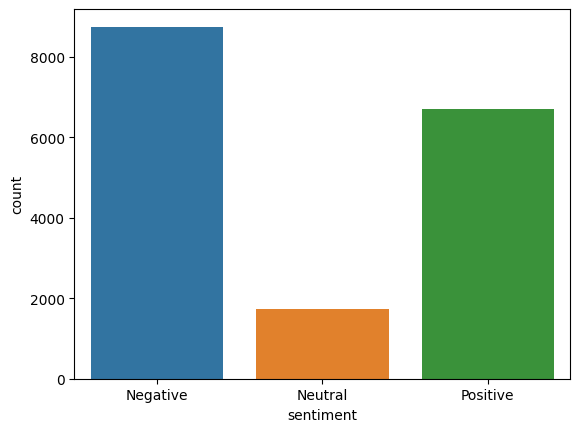

In [167]:
sns.countplot(x='sentiment', data = df_cleaned)

In [168]:
positive_comments = ' '.join(list(df_cleaned[df_cleaned.sentiment == 'Positive']['clean_comment']))
negative_comments = ' '.join(list(df_cleaned[df_cleaned.sentiment == 'Negative']['clean_comment']))
neutral_comments = ' '.join(list(df_cleaned[df_cleaned.sentiment == 'Neutral']['clean_comment']))

In [169]:
def create_word_cloud(data):
    data_wc = WordCloud(width=600,height=512).generate(data)
    plt.figure(figsize=(13,9))
    plt.imshow(data_wc)
    plt.show()

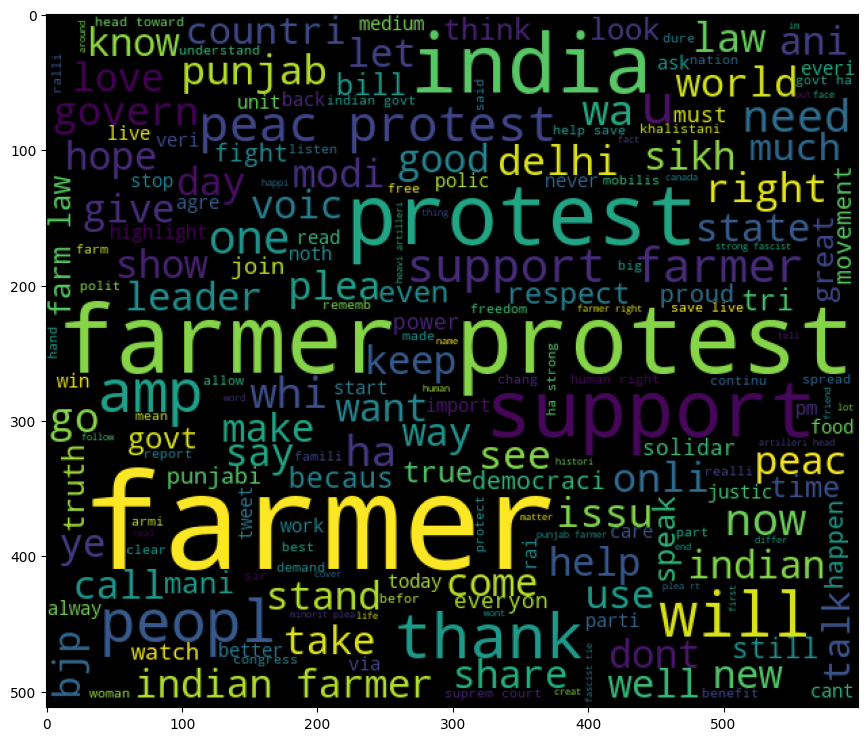

In [170]:
create_word_cloud(positive_comments)

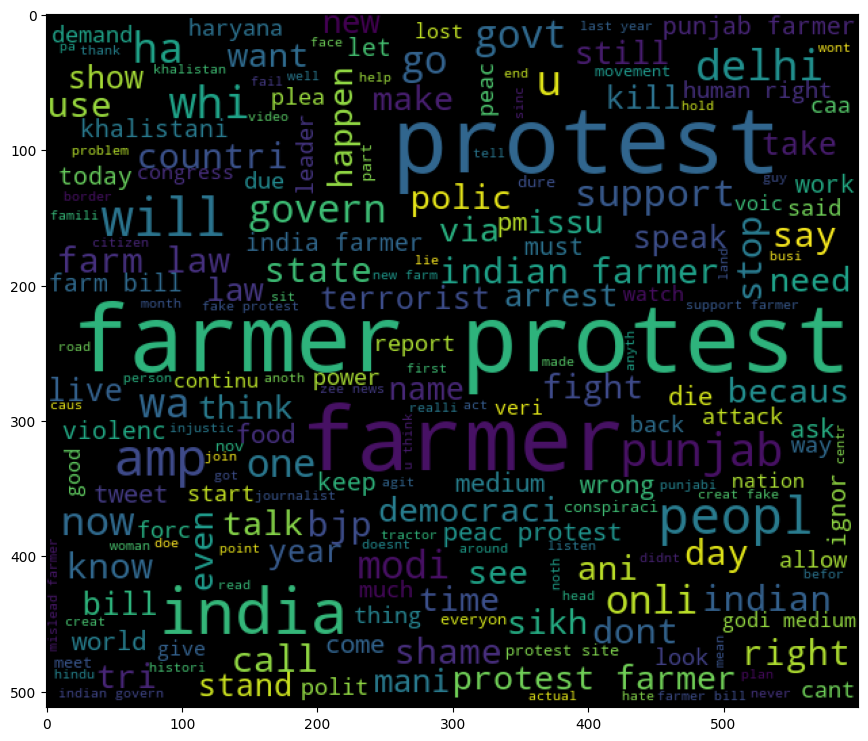

In [171]:
create_word_cloud(negative_comments)

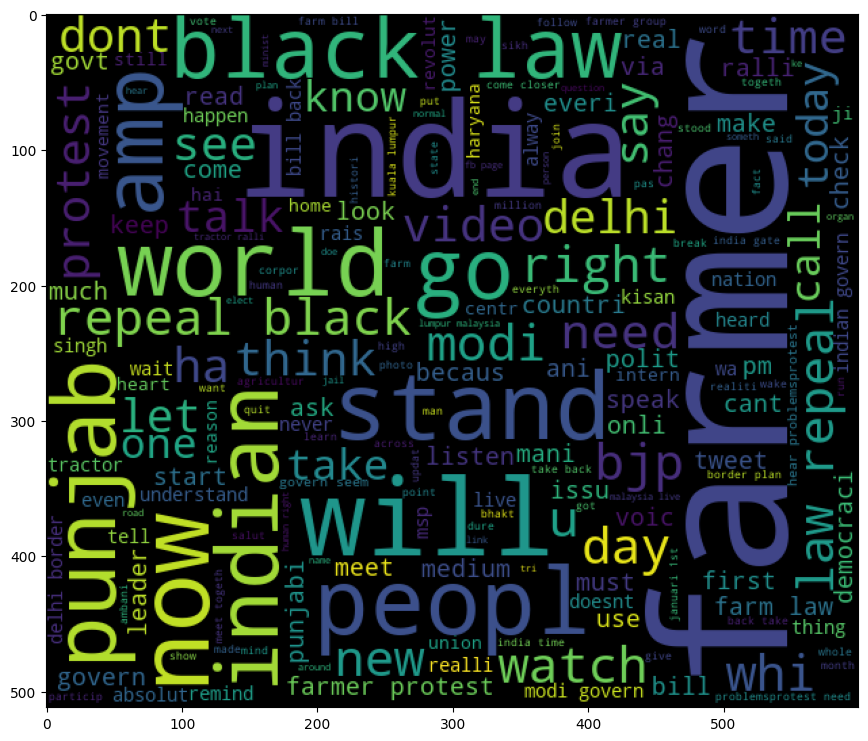

In [172]:
create_word_cloud(neutral_comments)

In [173]:
X = df_cleaned['clean_comment'].values
y = df_cleaned['sentiment'].values

In [174]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
y

array([0, 0, 0, ..., 2, 0, 2])

In [175]:
tokenizer = Tokenizer(num_words=1500, split=' ')

tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1)
print("X_train Shape : ",X_train.shape)
print("y_train Shape : ",y_train.shape)
print("X_test Shape : ",X_test.shape)
print("y_test Shape : ",y_test.shape)

X_train Shape :  (12015, 56)
y_train Shape :  (12015,)
X_test Shape :  (5150, 56)
y_test Shape :  (5150,)


In [177]:
embed_dim = 128
lstm_out = 196
model = Sequential()
model.add(Embedding(10018, embed_dim,input_length = X_train.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 56, 128)           1282304   
                                                                 
 lstm_4 (LSTM)               (None, 196)               254800    
                                                                 
 dense_8 (Dense)             (None, 3)                 591       
                                                                 
Total params: 1,537,695
Trainable params: 1,537,695
Non-trainable params: 0
_________________________________________________________________


In [178]:
history = model.fit(X_train, y_train,validation_data = (X_test,y_test),epochs = 5, batch_size=32)

Epoch 1/5
376/376 [==============================] - 60s 154ms/step - loss: 0.6606 - accuracy: 0.7015 - val_loss: 0.4614 - val_accuracy: 0.8179
Epoch 2/5
376/376 [==============================] - 52s 138ms/step - loss: 0.4081 - accuracy: 0.8444 - val_loss: 0.4349 - val_accuracy: 0.8270
Epoch 3/5
376/376 [==============================] - 57s 151ms/step - loss: 0.3546 - accuracy: 0.8691 - val_loss: 0.4271 - val_accuracy: 0.8301
Epoch 4/5
376/376 [==============================] - 61s 162ms/step - loss: 0.3190 - accuracy: 0.8818 - val_loss: 0.4351 - val_accuracy: 0.8435
Epoch 5/5
376/376 [==============================] - 61s 161ms/step - loss: 0.2819 - accuracy: 0.8953 - val_loss: 0.3983 - val_accuracy: 0.8414


In [179]:
model.evaluate(X_test,y_test)

161/161 [==============================] - 4s 23ms/step - loss: 0.3983 - accuracy: 0.8414


[0.39833495020866394, 0.8413591980934143]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


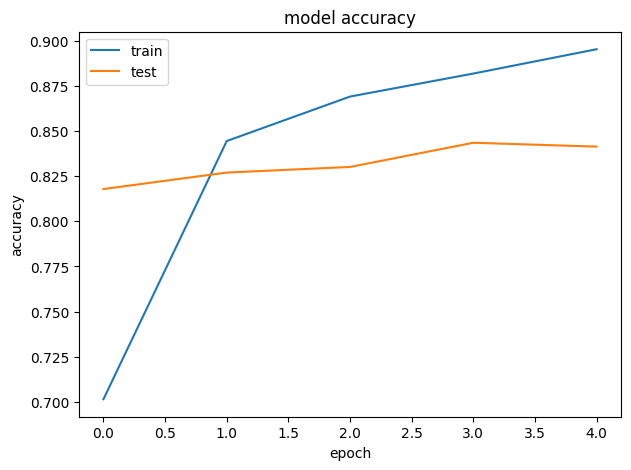

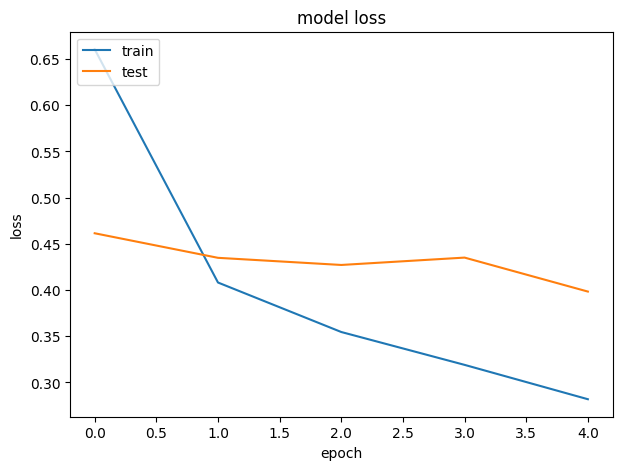

In [180]:
plt.figure(figsize = (7,5))
print(history.history.keys())
# Accuracy vs Epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss vs Epochs
plt.figure(figsize = (7,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [181]:
yhat = model.predict(X_test)
yhat

161/161 [==============================] - 4s 22ms/step


array([[9.7919744e-01, 9.6529914e-04, 1.9837214e-02],
       [9.8588932e-01, 9.9075504e-04, 1.3119935e-02],
       [1.3953407e-01, 1.2923831e-02, 8.4754211e-01],
       ...,
       [3.5014834e-02, 9.4853431e-01, 1.6450768e-02],
       [9.9412316e-01, 7.5054413e-04, 5.1263659e-03],
       [6.6023117e-01, 2.9959504e-03, 3.3677295e-01]], dtype=float32)

In [182]:
yhat=np.argmax(yhat,axis=1)
yhat

array([0, 0, 2, ..., 1, 0, 0], dtype=int64)

Text(50.722222222222214, 0.5, 'predicted')

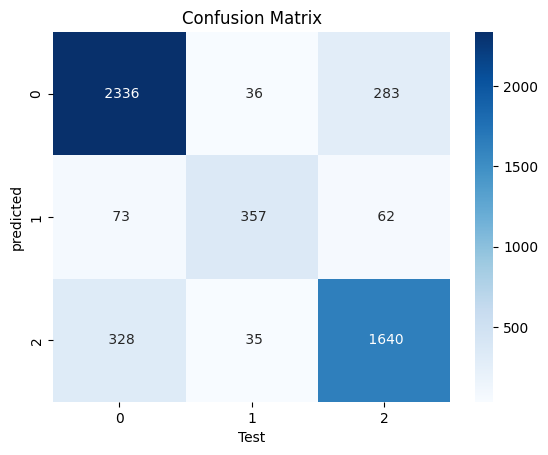

In [183]:
cm=confusion_matrix(y_test,yhat)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Test')
ax.set_ylabel('predicted')

In [184]:
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      2655
           1       0.83      0.73      0.78       492
           2       0.83      0.82      0.82      2003

    accuracy                           0.84      5150
   macro avg       0.84      0.81      0.82      5150
weighted avg       0.84      0.84      0.84      5150



In [185]:
stop_words = set(stopwords.words('english'))

In [186]:
def remove_stopwords(text):
    tokenized = word_tokenize(text)
    nostopwords = ' '.join([word for word in tokenized if word not in stop_words])
    return nostopwords

In [187]:
df_cleaned['clean_comment'] = df_cleaned['clean_comment'].apply(remove_stopwords)
df_cleaned.head()

,clean_comment,sentiment
0,pakistani armi extract farmer farmer protest shower bullet ann,Negative
1,editor nonstun export ban spark mass farmer protest across poland,Negative
2,pti kept islamabad hijack month attempt throw democrat govern pmln cant bear protest right group administr use baton charg tear gas chemic laden water protest farmer kill ashfaq langriy,Negative
3,malik ishfaq langrial pas away punjab polic tortur sustain injuri yesterday dure protest lahor demand farmer right,Negative
4,farmer postpon protest batoncharg arrest pakistan,Negative


In [188]:
D=20
i=Input((T,))
x=Embedding(len(tokenizer.word_index)+1,D)(i)
x=Conv1D(32,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(5,activation='softmax')(x)
modelcnn=Model(i,x)
modelcnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 56)]              0         
                                                                 
 embedding_9 (Embedding)     (None, 56, 20)            329320    
                                                                 
 conv1d_12 (Conv1D)          (None, 54, 32)            1952      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 18, 32)           0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 16, 64)            6208      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 5, 64)            0         
 1D)                                                       

In [189]:
modelcnn.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_senti=modelcnn.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=32)

Epoch 1/5
376/376 [==============================] - 4s 9ms/step - loss: 0.8512 - accuracy: 0.5769 - val_loss: 0.6883 - val_accuracy: 0.6817
Epoch 2/5
376/376 [==============================] - 3s 7ms/step - loss: 0.6124 - accuracy: 0.7267 - val_loss: 0.6026 - val_accuracy: 0.7350
Epoch 3/5
376/376 [==============================] - 3s 7ms/step - loss: 0.5288 - accuracy: 0.7659 - val_loss: 0.6172 - val_accuracy: 0.7328
Epoch 4/5
376/376 [==============================] - 3s 7ms/step - loss: 0.4682 - accuracy: 0.7949 - val_loss: 0.6205 - val_accuracy: 0.7417
Epoch 5/5
376/376 [==============================] - 3s 7ms/step - loss: 0.4015 - accuracy: 0.8261 - val_loss: 0.6669 - val_accuracy: 0.7379


In [190]:
yhatcnn=modelcnn.predict(X_test)
yhatcnn

161/161 [==============================] - 0s 2ms/step


array([[9.9461901e-01, 2.0152784e-03, 3.3656270e-03, 6.8417867e-14,
        2.3048810e-13],
       [9.9542749e-01, 1.5168732e-04, 4.4208150e-03, 3.8372391e-12,
        1.1657011e-11],
       [1.9916627e-03, 7.6396042e-05, 9.9793196e-01, 9.7862769e-21,
        1.5929668e-19],
       ...,
       [4.6436280e-01, 2.8680816e-01, 2.4882889e-01, 7.7280134e-08,
        1.3255973e-07],
       [9.9953818e-01, 2.8374285e-05, 4.3345266e-04, 2.7326625e-13,
        8.8614462e-13],
       [4.3130374e-01, 6.7258431e-03, 5.6197035e-01, 1.0838475e-09,
        3.0435718e-09]], dtype=float32)

In [191]:
yhatcnn=np.argmax(yhatcnn,axis=1)
yhatcnn

array([0, 0, 2, ..., 0, 0, 2], dtype=int64)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


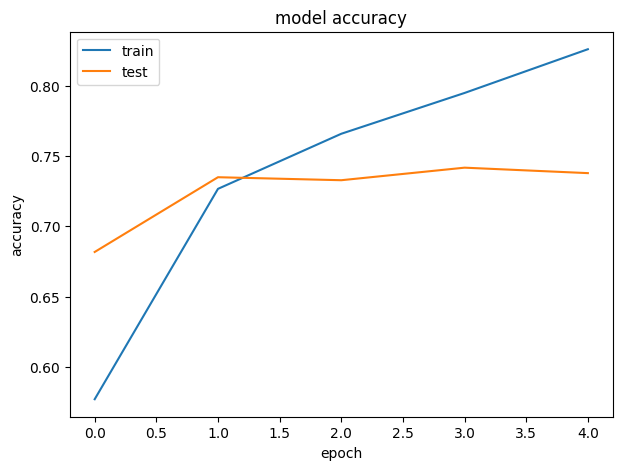

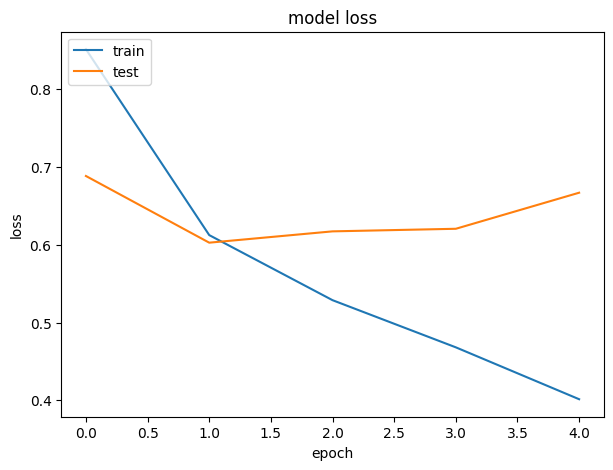

In [192]:
plt.figure(figsize = (7,5))
print(history.history.keys())
# Accuracy vs Epochs
plt.plot(cnn_senti.history['accuracy'])
plt.plot(cnn_senti.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss vs Epochs
plt.figure(figsize = (7,5))
plt.plot(cnn_senti.history['loss'])
plt.plot(cnn_senti.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Text(50.722222222222214, 0.5, 'predicted')

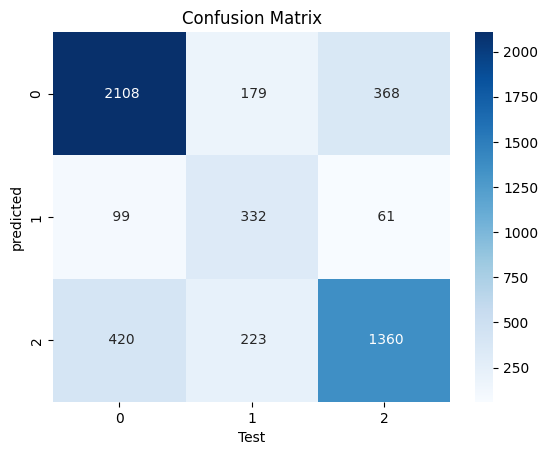

In [193]:
cm=confusion_matrix(y_test,yhatcnn)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Test')
ax.set_ylabel('predicted')

In [194]:
print(classification_report(y_test,yhatcnn))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2655
           1       0.45      0.67      0.54       492
           2       0.76      0.68      0.72      2003

    accuracy                           0.74      5150
   macro avg       0.67      0.72      0.69      5150
weighted avg       0.75      0.74      0.74      5150

